### Import all necessary libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.dates import num2date, date2num
warnings.simplefilter("ignore")
%matplotlib inline

### Get stock data from Yahoo Finance
I have chosen Bajaj Finance as an example. It is a high beta stocks and thus provides opportunites for short term (less than 365 days) trading.
Each entry represents 1 day staring from 1 Jan 2011

In [2]:
import yfinance as yf
ticker='BAJFINANCE.NS'
tickerData = yf.Ticker(ticker)
df = tickerData.history(period='1d', start='2011-1-1')

### Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. The indicator was originally developed by J. Welles Wilder Jr. and introduced in his seminal 1978 book, "New Concepts in Technical Trading Systems."

Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition.

In [3]:
def rsi(df, window=14):
    close = df['Close']
    
    # Price increase or decrease over previous day
    dif = close.diff()
    dif = dif[1:] 
    
    # pos_m identifies stock price going up
    # neg_m udentifies stock price going down
    pos_m, neg_m = dif.copy(), dif.copy()
    pos_m[pos_m < 0] = 0
    neg_m[neg_m > 0] = 0
    
    # Positive Rolling Mean Exponential
    prme = pos_m.ewm(span=window).mean()
    # Negative Rolling Mean Exponential
    nrme = neg_m.abs().ewm(span=window).mean()
    
    # Ratio of magnitude of up move to down move
    RSE = prme / nrme
    RSIE = 100.0 - (100.0 / (1.0 + RSE))
    df['rsie'] = RSIE
    
    # Positive Rolling Mean Simple
    prms = pos_m.rolling(window).mean()
    # Negative Rolling Mean Simple
    nrms = neg_m.abs().rolling(window).mean()

    RSS = prms / nrms
    RSIS = 100.0 - (100.0 / (1.0 + RSS))
    
    df['rsis'] = RSIS
    return df
df = rsi(df)

In [4]:
df['Date'] = df.index
df['DateY'] = df['Date'].apply(lambda x: date2num(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")))

In [5]:
def candlestick(ax, quotes, width=0.2, colorup='g', colordown='r', alpha=1.0):
    OFFSET = width / 2.0

    lines = []
    patches = []
    for q in quotes:
        t, open, close, high, low = q[:5]

        if close >= open:
            color = colorup
            lower = open
            height = close - open
        else:
            color = colordown
            lower = close
            height = open - close

        vline = Line2D(
            xdata=(t, t), ydata=(low, high),
            color=color,
            linewidth=0.5,
            antialiased=True,
        )

        rect = Rectangle(
            xy=(t - OFFSET, lower),
            width=width,
            height=height,
            facecolor=color,
            edgecolor=color,
        )
        rect.set_alpha(alpha)

        lines.append(vline)
        patches.append(rect)
        ax.add_line(vline)
        ax.add_patch(rect)
    ax.autoscale_view()

    return lines, patches

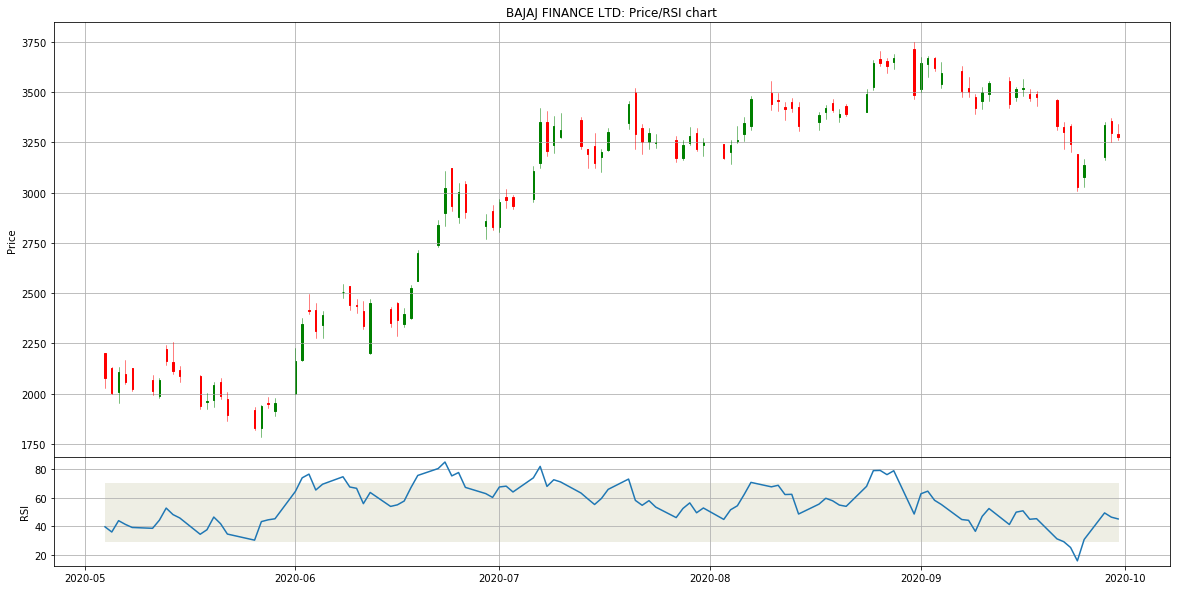

In [6]:
def plot_rsi(df, start_date='2020-05-01', end_date='2020-09-30'):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    df = df[(df.index>=start_date) & (df.index<=end_date)]
    ax1 = plt.subplot2grid((5,4), (0,0), rowspan=4, colspan=4)
    
    candlestick(ax1, np.array(df[['DateY', 'Open', 'Close', 'High', 'Low']]))
    plt.title("BAJAJ FINANCE LTD: Price/RSI chart")
    plt.ylabel("Price")
    ax1.grid(True)
    
    ax2 = plt.subplot2grid((5,4), (4,0), rowspan=1, colspan=4, sharex=ax1)
    ax2.fill_between(num2date(df['DateY']), 30, 70, color = '#eeeee4')
    ax2.plot(num2date(df['DateY']), df['rsie'])
    plt.ylabel("RSI")
    ax2.grid(True)
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

plot_rsi(df)